# Statoil Iceberg Clsfr

28 Nov Attempt

### NOTE:

~~I wasn't able to transfer over weights of a pretrained model using `.from_arrays` and kept having a lot of very strange size issues: siez set to 256, but is 75 when not precomputing activations, and is 1024 when precomputing... Also unable to resize images in array form -- could do it, but it's a lot simpler when loading data `.from_paths`.~~

~~I'll leave this as is for now/indefinitely, and carry on using the `.from_paths` method.~~

Fuck that noise. I threw another couple hours into the furnace and came up with a way to resize my Radar-band arrays w/ bilinear interpolation, and also account for the channel dim being at index -1 or 1.

I may continue this notebook later, or leave it as a scratch-pad, and take what I learned to a fresh notebook. That said, I probably could've resized things faster if i found a way to vectorize (?) my code (I'm understanding that as "*don't use loops!*") and use the PIL. So... may dive in all the way and try to contribute to the FastAI library - as it's `.from_arrays` dataloader method doesn't have resizing support yet - or just switch to using `.from_paths`.

W.Nixalo - `01:47 29 November 2017`

In [155]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from sklearn import metrics

import json

In [197]:
PATH = 'data/'
PLANET_PRETRAINED_MODEL = '../Kaukasos/FADL1/data/planet/models/256'

In [28]:
with open(PATH + 'train.json') as jfile:
    train_data = json.load(jfile)
with open(PATH + 'test.json') as jfile:
    test_data  = json.load(jfile)

In [29]:
train_data[0].keys()

dict_keys(['id', 'band_1', 'band_2', 'inc_angle', 'is_iceberg'])

In [30]:
test_data[0].keys()

dict_keys(['id', 'band_1', 'band_2', 'inc_angle'])

In [27]:
# # I don't see a reason to load these into memory or save to disk just yet
# train_ids = [train_data[i]['id'] for i in train_data]
# test_ids  = [test_data[i]['id'] for i in test_data]

# train_angles = [train_data[i]['inc_angle'] for i in train_data]
# test_anngles = [test_data[i]['inc_angle'] for i in test_data]

5625

Haven't decided yet to use fastai's `from_path` or `from_array`

In [105]:
def array_to_np_band(data_array, key=None):
    """Returns an (n,75,75,1) ndarray from Statoil radar bands"""
    if key==None:
        print("Error: Key not specified")
        return
    return np.expand_dims(np.array([np.array(band[key]).astype(np.float32).reshape(75,75) for 
                     band in data_array]), axis=-1)

In [178]:
train_band_1 = array_to_np_band(train_data, 'band_1')
train_band_2 = array_to_np_band(train_data, 'band_2')
train_band_z = np.zeros(train_band_1.shape).astype(np.float32)

In [179]:
train_band_data = np.concatenate([train_band_1, train_band_2, train_band_z], axis=-1)

In [180]:
train_band_data.shape

(1604, 75, 75, 3)

In [181]:
train_band_data.dtype

dtype('float32')

In [189]:
test_band_1 = array_to_np_band(test_data, 'band_1')
test_band_2 = array_to_np_band(test_data, 'band_2')
test_band_z = np.zeros(test_band_1.shape).astype(np.float32)

test_band_data = np.concatenate([test_band_1, test_band_2, test_band_z], axis=-1)

In [190]:
test_band_data.dtype

dtype('float32')

In [183]:
labels = [datum['is_iceberg'] for datum in train_data]

In [141]:
arr = np.array([chr(ord('α') + i) for i in range(10)])
# arr = np.array([-2*i for i in range(10)])
idxs = np.array([0,1,2])

print(arr)
temp = arr[idxs]
print(temp)
temp = np.delete(arr, idxs)
print(temp)

['α' 'β' 'γ' 'δ' 'ε' 'ζ' 'η' 'θ' 'ι' 'κ']
['α' 'β' 'γ']
['δ' 'ε' 'ζ' 'η' 'θ' 'ι' 'κ']


In [142]:
??get_cv_idxs

In [154]:
# Here learning that making a thing a NumPy array multiple times doesn't mess it up
temp = [0]
temp = np.array(temp)
temp = np.array(temp)
temp.shape

(1,)

In [184]:
n = len(labels)
val_idxs = get_cv_idxs(n)

labels = np.array(labels)

train_array = (np.delete(train_band_data, val_idxs, axis=0), np.delete(labels, val_idxs))
val_array = (train_band_data[np.array(val_idxs)], labels[(np.array(val_idxs))])

In [192]:
val_array[0].dtype

dtype('float32')

In [160]:
len(test_band_data)

8424

In [162]:
labels[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0])

In [165]:
test_dummy_ys = np.zeros(len(test_band_data)).astype('int')

In [185]:
train_array[0].shape

(1284, 75, 75, 3)

In [186]:
train_band_data.shape

(1604, 75, 75, 3)

In [166]:
test_dummy_ys[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [223]:
f_model = resnet34
sz = 256

tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_arrays(PATH, train_array, val_array, bs=24, 
                                       tfms=tfms, classes=['0','1'], test=test_band_data)
                                       #test=(test_band_data, np.zeros(len(test_band_data))))

learn = ConvLearner.pretrained(f_model, data, metrics=metrics, precompute=False)

In [215]:
f_model = resnet34
def get_data(sz,bs=24):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_arrays(PATH, train_array, val_array, tfms=tfms, bs=bs, 
                                           classes=['0','1'], test=test_band_data)
#     return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms, bs=bs,
#                                         suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

data = get_data(sz=256)
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

In [225]:
learn.data.sz

75

In [221]:
data = data.resize(256, 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

AttributeError: 'ArraysIndexDataset' object has no attribute 'resize_imgs'

In [217]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 75, 75]),
                           ('output_shape', [-1, 64, 38, 38]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 38, 38]),
                           ('output_shape', [-1, 64, 38, 38]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 38, 38]),
                           ('output_shape', [-1, 64, 38, 38]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 38, 38]),
                           ('output_shape', [-1, 64, 19, 19]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 19, 19]),
        

In [214]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 75, 75]),
                           ('output_shape', [-1, 64, 38, 38]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 38, 38]),
                           ('output_shape', [-1, 64, 38, 38]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 38, 38]),
                           ('output_shape', [-1, 64, 38, 38]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 38, 38]),
                           ('output_shape', [-1, 64, 19, 19]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 19, 19]),
        

In [222]:
learn.load(f'../../{PLANET_PRETRAINED_MODEL}')

While copying the parameter named 0.weight, whose dimensions in the model are torch.Size([1024]) and whose dimensions in the checkpoint are torch.Size([64, 3, 7, 7]), ...


RuntimeError: invalid argument 2: sizes do not match at /opt/conda/conda-bld/pytorch_1511320797808/work/torch/lib/THC/generic/THCTensorCopy.c:48

---

Testing manual Linear (Bilinear?) interpolation of the data arrays as a way through.

In [274]:
temp = train_array[0][0]

In [249]:
plt.style.library.keys()

dict_keys(['seaborn', 'fivethirtyeight', 'classic', 'seaborn-whitegrid', 'seaborn-dark-palette', 'seaborn-notebook', 'fast', 'seaborn-deep', 'seaborn-muted', 'seaborn-ticks', 'seaborn-colorblind', 'seaborn-white', 'seaborn-bright', 'Solarize_Light2', 'ggplot', 'bmh', 'grayscale', 'seaborn-poster', 'seaborn-paper', '_classic_test', 'seaborn-darkgrid', 'seaborn-talk', 'seaborn-pastel', 'seaborn-dark', 'dark_background'])

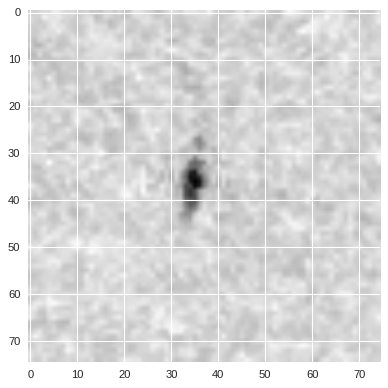

In [267]:
plt.style.use('seaborn') # https://matplotlib.org/devdocs/gallery/style_sheets/style_sheets_reference.html
plt.imshow(temp[:,:,0]);

In [269]:
factor = 256/75

In [270]:
factor

3.4133333333333336

In [272]:
import scipy.ndimage

In [ ]:
temp = train_array[0][0]

In [ ]:
temp = scipy.ndimage.zoom(temp, factor, order=1)

In [273]:
temp.shape

(256, 256, 10)

In [276]:
temp = train_array[0][0]
temp = scipy.ndimage.zoom(temp[:,:,0], factor, order=1)
temp.shape

(256, 256)

In [279]:
train_array[0][1].shape

(75, 75, 3)

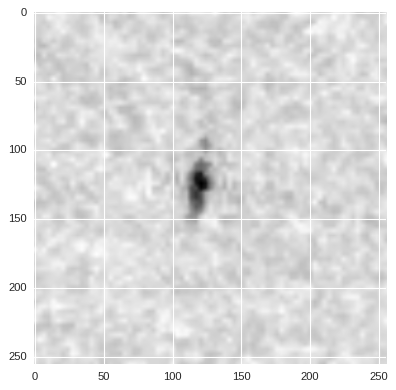

In [277]:
plt.imshow(temp)

Okay, *looks* like I have something I can work with here..

Now how can I resize specific dimensions of a tensor in a vectorized form, so that I don't have to write a python loop that'll take forever?

In [290]:
temp_arr = train_band_data[:3]

In [291]:
temp_arr.shape

(3, 75, 75, 3)

In [295]:
scipy.ndimage.zoom(temp_arr[0,:,:,0], factor, order=1).shape

(256, 256)

In [324]:
temp.shape

(75, 75, 3)

In [325]:
[i for i in range(temp.shape[-1])]

[0, 1, 2]

It seems as though I had my dimensions mixed up. Looks like the channel-dimensionality (3) should go before the image sizes, not after. So (n, 3, 75, 75) instead of (n, 75, 75, 3).

In [382]:
arr = np.array([i for i in range(30)])
print(arr.shape)
arr = np.array([arr])
print(arr.shape)

(30,)
(1, 30)


In [383]:
arr

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
        25, 26, 27, 28, 29]])

In [385]:
arr2 = np.array([99 for i in range(30)])
arr2 = np.array([arr2])
arr2.shape

(1, 30)

In [387]:
np.concatenate((arr, arr2)).shape

(2, 30)

In [379]:
temp = np.copy(temp_arr[0])
print(temp.shape)
temp1 = np.array([scipy.ndimage.zoom(temp[:,:,i], 1, order=1) for i in range(temp.shape[-1])])
temp1 = np.reshape(temp1, (75, 75, 3))
np.flip(temp1, )
print(temp1.shape)

(75, 75, 3)
(75, 75, 3)


In [388]:
# [temp[i][0]==temp1[i][0] for i in range(len(temp))]

In [402]:
temp_arr = np.copy(train_band_data[:10]) # I think the np.copy is unnec.

temp_arr = np.array([[scipy.ndimage.zoom(temp_arr[n,:,:,i], 1, order=1) for 
                                        i in range(temp_arr.shape[-1])] for 
                                        n in range(temp_arr.shape[0])])

print(temp_arr.shape)

# just testing it won't go wonky
temp_arr = np.array([[scipy.ndimage.zoom(temp_arr[n,i,:,:], 1, order=1) for 
                                        i in range(temp_arr.shape[1])] for 
                                        n in range(temp_arr.shape[0])])
print(temp_arr.shape)
temp_arr = np.array([[scipy.ndimage.zoom(temp_arr[n,i,:,:], 1, order=1) for 
                                        i in range(temp_arr.shape[1])] for 
                                        n in range(temp_arr.shape[0])])
print(temp_arr.shape)

(10, 3, 75, 75)
(10, 3, 75, 75)
(10, 3, 75, 75)


In [391]:
np.isclose(train_band_data[0,:,:,0], temp_arr[0,0,:,:])

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

Okay... we have a starting point.

---

Trying to continue, with my own way of resizing images. Automate it some..

In [412]:
def resize_arr(data_array, size):
    """Resizes only the image-dimensions of an ndimage via bilinear interpolation.
       Assumes NxN images!
    """
    # If dimensions ordering is wrong, they'll set to 'correct' order
    # This is done by checking if the last dim is less than the 2nd to last,
    # assuming the image's rows|cols are > than its num_channels
    if data_array.shape[-1] < data_array.shape[-2]:
        data_array = np.array([[scipy.ndimage.zoom(data_array[n,:,:,i], 1, order=1) for 
                                i in range(data_array.shape[-1])] for 
                               n in range(data_array.shape[0])])
    factor = size / data_array.shape[2]
    data_array = np.array([[scipy.ndimage.zoom(data_array[n,i,:,:], factor, order=1) for 
                            i in range(data_array.shape[1])] for 
                           n in range(data_array.shape[0])])
    return data_array

In [417]:
temp_arr = train_band_data[:100]
print(temp_arr.shape)
%time temp_arr = resize_arr(temp_arr, 75)
print(temp_arr.shape)
%time temp_arr = resize_arr(temp_arr, 256)
print(temp_arr.shape)
# just testing time
%time temp_arr = resize_arr(temp_arr, 512)
print(temp_arr.shape)

(100, 75, 75, 3)
CPU times: user 100 ms, sys: 4 ms, total: 104 ms
Wall time: 100 ms
(100, 3, 75, 75)
CPU times: user 436 ms, sys: 32 ms, total: 468 ms
Wall time: 467 ms
(100, 3, 256, 256)
CPU times: user 1.72 s, sys: 128 ms, total: 1.84 s
Wall time: 1.84 s
(100, 3, 512, 512)


Okay.. I'm sure there's a much better way to do this... hell if the function doing the resizing could just can over every element instead having to be called for each element.. that'd speed things up a lot.. But I don't know how to do that yet.

That said, 436 ms to resize 100 75x75 images to 256x256 works for me when there are only ~1600 images in the training set, and ~8600 in the test set.

Hell... okay first, what if I used PIL (or OpenCV, but I think fastai switched back) to do this... there's a speedup.. and all this'd be a hell of a lot faster if I just used `.from_paths` as my dataloader.

This is an exercise in stubbornness. I may switch to `.from_paths` later anyway, but at least now I know I have a way to resize my RADAR-band arrays as I like.

`01:39 29 November 2017`. I'll continue this in the-- later in the morning.

In [278]:
test_band_data.shape

(8424, 75, 75, 3)

```
test_band_data = np.concatenate([test_band_1, test_band_2, test_band_z], axis=-1)
train_array, val_array, test_band_data
```

---

In [87]:
len(train_data[0]['band_1'])

5625

In [48]:
temp = train_data[0]['band_1']

In [52]:
temp = np.reshape(temp, (75,75))

In [58]:
temp = temp[:,:,np.newaxis]

In [59]:
temp.shape

(75, 75, 1)

In [50]:
temp = np.reshape(temp, (75, 75, 1))

In [46]:
temp = np.reshape(temp, (1, 75, 75))

In [51]:
temp.shape

(75, 75, 1)